# Sprint 20 セグメンテーション2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#このSprintについて" data-toc-modified-id="このSprintについて-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>このSprintについて</a></span><ul class="toc-item"><li><span><a href="#Sprintの目的" data-toc-modified-id="Sprintの目的-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sprintの目的</a></span></li><li><span><a href="#どのように学ぶか" data-toc-modified-id="どのように学ぶか-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>どのように学ぶか</a></span></li></ul></li><li><span><a href="#セグメンテーションの精度向上" data-toc-modified-id="セグメンテーションの精度向上-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>セグメンテーションの精度向上</a></span><ul class="toc-item"><li><span><a href="#【問題1】コードレビュー" data-toc-modified-id="【問題1】コードレビュー-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>【問題1】コードレビュー</a></span></li><li><span><a href="#IMPORT" data-toc-modified-id="IMPORT-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>IMPORT</a></span><ul class="toc-item"><li><span><a href="#Data-loading-&amp;-depth-merge:¶" data-toc-modified-id="Data-loading-&amp;-depth-merge:¶-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Data loading &amp; depth merge:¶</a></span></li></ul></li><li><span><a href="#Compute-salt-coverage-(this-will-serve-as-a-basis-for-stratified-split):" data-toc-modified-id="Compute-salt-coverage-(this-will-serve-as-a-basis-for-stratified-split):-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Compute salt coverage (this will serve as a basis for stratified split):</a></span></li><li><span><a href="#Prepare-data-for-training:" data-toc-modified-id="Prepare-data-for-training:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Prepare data for training:</a></span></li><li><span><a href="#Encoder-features---ResNet50:" data-toc-modified-id="Encoder-features---ResNet50:-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Encoder features - ResNet50:</a></span></li><li><span><a href="#Decoder-blocks:" data-toc-modified-id="Decoder-blocks:-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Decoder blocks:</a></span></li><li><span><a href="#Model-definition:" data-toc-modified-id="Model-definition:-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Model definition:</a></span></li><li><span><a href="#Inspect-created-model:" data-toc-modified-id="Inspect-created-model:-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Inspect created model:</a></span></li><li><span><a href="#Train-model:" data-toc-modified-id="Train-model:-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Train model:</a></span></li><li><span><a href="#【問題2】コードの書き換え" data-toc-modified-id="【問題2】コードの書き換え-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>【問題2】コードの書き換え</a></span></li><li><span><a href="#【問題3】学習・推定" data-toc-modified-id="【問題3】学習・推定-2.11"><span class="toc-item-num">2.11&nbsp;&nbsp;</span>【問題3】学習・推定</a></span></li></ul></li></ul></div>

## このSprintについて

### Sprintの目的
* セグメンテーションの精度を向上させる

### どのように学ぶか
Kaggleコンペティションの情報を参考にセグメンテーションの精度を向上させます。

## セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行います。

TGS Salt Identification Challenge | Kaggle  
https://www.kaggle.com/c/tgs-salt-identification-challenge

### 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。

《視点例》

* 前回使用した実装とはどのように違うのか
* 転移学習をどのように行っているか

* imagenetで学習したResNetのパラメータを使用している。（前回は、U-Netのみで初期値も設定無し）
* ResNetのパラメータも微調整している（エポック2）、追加層のみ学習（ResNetの凍結）はしていない

### IMPORT

In [66]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

In [67]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [68]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

#### Data loading & depth merge:¶

In [69]:
train = pd.read_csv('./tgs-salt-identification-challenge/train.csv')
test = pd.read_csv('./tgs-salt-identification-challenge/sample_submission.csv')
depth = pd.read_csv('./tgs-salt-identification-challenge/depths.csv')

train_src = './tgs-salt-identification-challenge/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test:
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1

           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


In [70]:
X_train = np.asarray(
    [cv2.imread('./tgs-salt-identification-challenge/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255. # unit.8
y_train = np.asarray(
    [cv2.imread('./tgs-salt-identification-challenge/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255. # unit.8

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


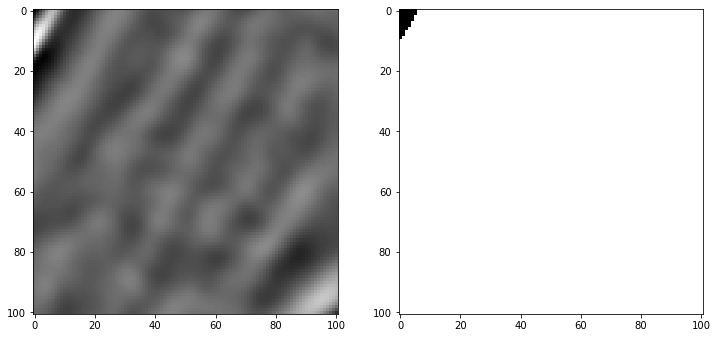

In [71]:
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray');

### Compute salt coverage (this will serve as a basis for stratified split):

In [72]:
train = compute_coverage(train, y_train)

### Prepare data for training:

In [73]:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/Users/kazuki/.pyenv/versions/anaconda3-2020.02/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


5028

In [74]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_function(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_function(get_iou_vector, [label, pred >0], tf.float64)

### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers. Default input size will be assumed, which is (224, 224, 3). Layers will be as follows:

* 'activation_1', shape: (None, 112, 112, 64)
* 'activation_10', shape: (None, 56, 56, 256)
* 'activation_22', shape: (None, 28, 28, 512)
* 'activation_40', shape: (None, 14, 14, 1024)
* 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call K.clear_session().

In [75]:
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
#base_model.summary()

### Decoder blocks:
Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed. For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

In [76]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### Model definition:
Combine encoder and decoder blocks to create final segmentation model.

In [87]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size,
                decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('conv1_conv').output # activation_1
    encoder2 = base_model.get_layer('conv2_block3_3_conv').output # activation_10
    encoder3 = base_model.get_layer('conv3_block4_3_conv').output # activation_22
    encoder4 = base_model.get_layer('conv4_block5_3_conv').output # activation_40
    encoder5 = base_model.get_layer('conv5_block2_3_conv').output # activation_40

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(inputs=base_model.input, outputs=output)
    #model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

### Inspect created model:

In [81]:
#import tf.compat.v1.keras.backend as K

input_size = (224, 224, 3)


tf.keras.backend.clear_session()
model = unet_resnet(input_size,
                    decoder_block_simple,
                    weights='imagenet')
#model.summary()

### Train model:

In [88]:
tf.keras.backend.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.

model_depth = unet_resnet(input_size, 
                          decoder_block_simple, # bottle
                          weights='imagenet',
                          #loss_func=bce_dice_loss, 
                          #metrics_list=[my_iou_metric],
                          use_lovash=False)

#print(model_depth.summary())


model_checkpoint = ModelCheckpoint('unet_resnet.h5',
                                   monitor='val_my_iou_metric', 
                                   mode='max',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric',
                              mode='max',
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=1)

epochs = 1  # 25
batch_size = 16

X_tr = X_tr.astype('float32')
y_tr = y_tr.astype('float32')

history = model_depth.fit(X_tr[:320],
                          y_tr[:320],
                          validation_data=[X_val[:32], y_val[:32]], 
                          epochs=epochs,
                          batch_size=batch_size,
                          #callbacks=[model_checkpoint,reduce_lr], 
                          verbose=1
                         )

Train on 320 samples, validate on 32 samples
320/320 [==============================] - ETA: 0s - loss: 0.4371 - acc: 0.8182 WARNING:tensorflow:From /Users/kazuki/.pyenv/versions/anaconda3-2020.02/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
320/320 [==============================] - 475s 1s/sample - loss: 0.4371 - acc: 0.8182 - val_loss: 11.0478 - val_acc: 0.2694


### 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [89]:
from keras.applications.vgg16 import VGG16, preprocess_input

def unet_vgg(input_size,
                decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('conv1_conv').output # activation_1
    encoder2 = base_model.get_layer('conv2_block3_3_conv').output # activation_10
    encoder3 = base_model.get_layer('conv3_block4_3_conv').output # activation_22
    encoder4 = base_model.get_layer('conv4_block5_3_conv').output # activation_40
    encoder5 = base_model.get_layer('conv5_block2_3_conv').output # activation_40

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(inputs=base_model.input, outputs=output)
    #model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [90]:
tf.keras.backend.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.

model_depth = unet_resnet(input_size, 
                          decoder_block_simple, # bottle
                          weights='imagenet',
                          #loss_func=bce_dice_loss, 
                          #metrics_list=[my_iou_metric],
                          use_lovash=False)

#print(model_depth.summary())


model_checkpoint = ModelCheckpoint('unet_resnet.h5',
                                   monitor='val_my_iou_metric', 
                                   mode='max',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric',
                              mode='max',
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=1)

epochs = 1  # 25
batch_size = 16

X_tr = X_tr.astype('float32')
y_tr = y_tr.astype('float32')

history = model_depth.fit(X_tr[:320],
                          y_tr[:320],
                          validation_data=[X_val[:32], y_val[:32]], 
                          epochs=epochs,
                          batch_size=batch_size,
                          #callbacks=[model_checkpoint,reduce_lr], 
                          verbose=1
                         )

Train on 320 samples, validate on 32 samples
320/320 [==============================] - 492s 2s/sample - loss: 0.5288 - acc: 0.7773 - val_loss: 11.0663 - val_acc: 0.2694


### 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

* データを1/10にして学習、推定を行った。
* ResNetのレイヤーを使用した方が精度は高かった。